In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, sin
from scipy import special as sp
import scipy.integrate as integrate
from scipy.interpolate import interp2d
from scipy.constants import fine_structure, speed_of_light, electron_mass, elementary_charge, hbar, epsilon_0

In [2]:
#variáveis e constantes
electron_radius = elementary_charge**2/(4*pi*epsilon_0*electron_mass*speed_of_light**2)
num_pon = 300                                                   #número de pontos
mean_ene = 1800                                                    #energia média inicial
std_div = 90                                                       #desvio padrão
mag_field = 7.48e6 #[T] intensidade do campo magnético
tau_e = hbar/(speed_of_light**2*electron_mass)                     #[s] time it takes for light to travel across the electron radius electron_radius/speed_of_light
n_bins = 75                                                        #número de bins do histograma
t_end = 2.2                              #tempos finais
t_steps = 4000                                                       #numero de steps
t_int = 2.2/4000
min_ene = 0.0001
max_ene = 3600
d_ene = min_ene/max_ene
ene_lst = np.linspace(min_ene, max_ene, num_pon)
time_lst = np.linspace(0, t_end, t_steps)

dfdt_mat = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_11_i = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_11_o = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_13 = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_22_i = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_22_o = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_23 = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_31 = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_32 = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_33 = np.zeros((3*num_pon,3*num_pon))

In [3]:
def cnst_prop_2(mag):
    return mag/(4.5*10**(9))

def bessel_integral(v):
    return integrate.quad(lambda x: sp.kv(5/3, x), v, np.Inf)[0]

#equacao 3.83 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def G_tilde_int(chi, epsilon):
    v = 2 * epsilon / (3 * chi * (1 - epsilon))
    return np.sqrt(3) / (2 * pi) * epsilon * (
                integrate.quad(lambda x: sp.kv(5 / 3, x), v, np.Inf)[
                    0] + 1.5 * epsilon * chi * v * sp.kv(2 / 3, v))

G_tilde_int_vec_aux = lambda chi1, epsilon1: G_tilde_int(chi1, epsilon1)

G_tilde_int_vec = np.vectorize(G_tilde_int_vec_aux)

epsilon_uni = np.linspace(0.0001, 0.9999, 10)

chi_uniform = np.linspace(0.00001, 10, 10)

epsilon_uni_2d, chi_uniform_2d = np.meshgrid(epsilon_uni, chi_uniform)

G_tilde_int_vec_aux_2 = G_tilde_int_vec(chi_uniform_2d, epsilon_uni_2d)

G_tilde_inter = interp2d(chi_uniform_2d, epsilon_uni_2d, G_tilde_int_vec_aux_2, kind='cubic')

#equacao 3.82 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def dN_dg(chi, epsilon):
    omega_c = elementary_charge * mag_field / (electron_mass * mean_ene)
    if chi/cnst_prop_2(mag_field) <= d_ene or epsilon * chi/cnst_prop_2(mag_field) <= d_ene or epsilon >= 1 or epsilon <= 0:
        return 0
    return (2 / 3) * fine_structure / tau_e / omega_c * G_tilde_inter(chi, epsilon) / (epsilon * (chi/cnst_prop_2(mag_field))**2)

In [4]:
#equacao 3.92 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def T_tilde(chi, epsilon):
    v_linha = 2/(3*epsilon*(1-epsilon))
    return np.sqrt(3)/(2*pi)*(1.5*(epsilon/chi)*v_linha*sp.kv(2/3, v_linha) - integrate.quad(lambda x: sp.kv(5 / 3, x), v_linha, np.Inf)[0])

T_tilde_int_vec_aux = lambda chi1, epsilon1: G_tilde_int(chi1, epsilon1)

T_tilde_int_vec = np.vectorize(G_tilde_int_vec_aux)

T_tilde_int_vec_aux_2 = T_tilde_int_vec(chi_uniform_2d, epsilon_uni_2d)

T_tilde_inter = interp2d(chi_uniform_2d, epsilon_uni_2d, G_tilde_int_vec_aux_2, kind='cubic')

#equacao 3.91 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def dN_dl(chi, epsilon):
    omega_c = elementary_charge * mag_field / (electron_mass * mean_ene)
    if chi/cnst_prop_2(mag_field) <= d_ene or epsilon * chi/cnst_prop_2(mag_field) <= d_ene or epsilon >= 1 or epsilon <= 0:
        return 0
    return (2 / 3) * fine_structure / tau_e / omega_c * T_tilde_inter(chi, epsilon) / ((chi/cnst_prop_2(mag_field))**2/epsilon)

In [5]:
# electron: outgoing
for i in range(num_pon):
    dfdt_mat_11_o[i, i] = -np.sum(
        np.array([dN_dg(ene_lst[i] * cnst_prop_2(mag_field), g/ene_lst[i]) for g in ene_lst[ene_lst < ene_lst[i]]])) * d_ene

# electron: ingoing
for i in range(num_pon):
    for j in range(i, num_pon):
        dfdt_mat_11_i[i, j] = dN_dg(ene_lst[j]*cnst_prop_2(mag_field) , (ene_lst[j] - ene_lst[i])/ene_lst[j]) * d_ene
# electron: pair production
for i in range(num_pon):
    for j in range(i, num_pon):
        dfdt_mat_13[i, 2 * num_pon + j] = dN_dl(ene_lst[i]*cnst_prop_2(mag_field), ene_lst[i]/ene_lst[j]) * d_ene

# positron: outgoing
for i in range(num_pon):
    dfdt_mat_22_o[num_pon + i, num_pon + i] = -np.sum(
        np.array([dN_dg(ene_lst[i] * cnst_prop_2(mag_field), g/ene_lst[i]) for g in ene_lst[ene_lst < ene_lst[i]]])) * d_ene
# positron: ingoing
for i in range(num_pon):
    for j in range(i, num_pon):
        dfdt_mat_22_i[num_pon + i, num_pon + j] = dN_dg(ene_lst[j]*cnst_prop_2(mag_field), (ene_lst[j] - ene_lst[i])/ene_lst[j]) * d_ene
# positron: pair production
for i in range(num_pon):
    for j in range(i, num_pon):
        dfdt_mat_23[num_pon + i, 2 * num_pon + j] = dN_dl(ene_lst[i]*cnst_prop_2(mag_field), ene_lst[i]/ene_lst[j]) * d_ene

# photon: photon production from leptons
for i in range(num_pon):
    for j in range(i, num_pon):
        # electrons
        dfdt_mat_31[2 * num_pon + i, 0 * num_pon + j] = dN_dg(ene_lst[j]*cnst_prop_2(mag_field),
                                                         ene_lst[i]/ene_lst[j]) * d_ene
        # positrons
        dfdt_mat_32[2 * num_pon + i, 1 * num_pon + j] = dN_dg(ene_lst[j]*cnst_prop_2(mag_field),
                                                         ene_lst[i]/ene_lst[j]) * d_ene
    # photon: photon decay
for i in range(num_pon):
    dfdt_mat_33[2 * num_pon + i, 2 * num_pon + i] = -np.sum(np.array(
        [dN_dl(g * cnst_prop_2(mag_field), ene_lst[i]/g) for g in
         ene_lst[(ene_lst < ene_lst[i]) + (ene_lst >= 2)]])) * d_ene

# add all submatrices
dfdt_mat = dfdt_mat_11_i + dfdt_mat_11_o + dfdt_mat_13 + dfdt_mat_22_i + dfdt_mat_22_o + dfdt_mat_23 + dfdt_mat_31 + dfdt_mat_32 + dfdt_mat_33

<ipython-input-5-57a4af6255c7>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dfdt_mat_33[2 * num_pon + i, 2 * num_pon + i] = -np.sum(np.array(


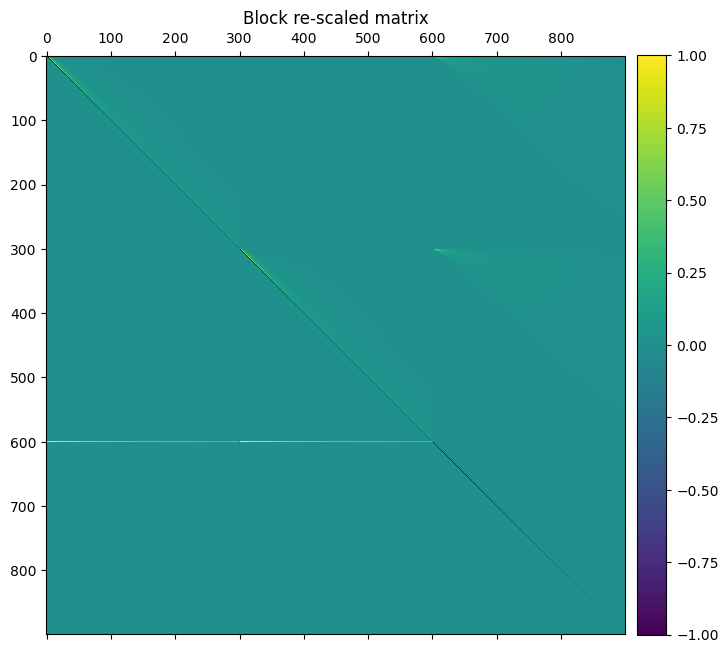

In [6]:
# re-scaled matrix
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
im0=axes.matshow(
    dfdt_mat_11_i/np.max(np.abs(dfdt_mat_11_i))
    +dfdt_mat_11_o/np.max(np.abs(dfdt_mat_11_o))
    +dfdt_mat_13/np.max(np.abs(dfdt_mat_13))
    +dfdt_mat_22_i/np.max(np.abs(dfdt_mat_22_i))
    +dfdt_mat_22_o/np.max(np.abs(dfdt_mat_22_o))
    +dfdt_mat_23/np.max(np.abs(dfdt_mat_23))
    +dfdt_mat_31/np.max(np.abs(dfdt_mat_31))
    +dfdt_mat_32/np.max(np.abs(dfdt_mat_32))
    +dfdt_mat_33/np.max(np.abs(dfdt_mat_33))
)
cbar0 = fig.colorbar(im0, ax=axes, fraction=0.0467, pad=0.02)
plt.title("Block re-scaled matrix")
plt.show()

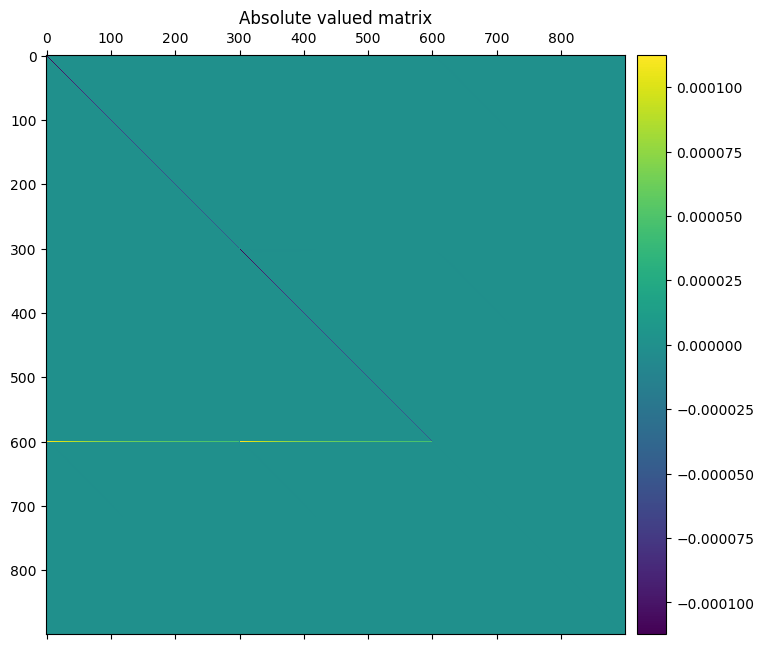

In [7]:
# absolute matrix
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
im0 = axes.matshow(dfdt_mat)
cbar0 = fig.colorbar(im0, ax=axes, fraction=0.0467, pad=0.02)
plt.title("Absolute valued matrix")
plt.show()